## Power Generation Optimization Model

### Objective Function
The objective of this optimization model is to minimize the total variable cost of electricity production across various power generators over a 24-hour period. This is represented as:

Minimize $\sum_{t \in \text{Time Periods}} \sum_{g \in \text{Generators}} (\text{Variable_Cost_per_MWh}[g] \times \text{gen_powers}[g,t])$

Where:

$\text{Time Periods}$ is the set of time intervals (e.g., each hour in a day).
$\text{Generators}$ is the set of all power generators.
$\text{Variable_Cost_per_MWh}[g]$ is the variable cost per MWh for generator $g$.
$\text{gen_powers}[g,t]$ represents the power output (in MWh) of generator $g$ during time period $t$.

### Decision Variables
#### Electricity Generation Variables (gen_powers):
These variables represent the power output of each generator for each time period.

For each generator $g$ and time period $t$, $\text{gen_powers}[g,t]$ is bounded by 0 and the capacity of the generator (in MWh).

#### Generator Status Variables (gen_on):
These binary variables indicate whether a generator is working  in a given time period.
For each generator $g$ and time period $t$, $\text{gen_on}[g,t]$ is a binary variable (1 if on, 0 if off).

### Constraints
#### Hourly Demand Constraint:
The total electricity generated across all generators must meet the specified demand for each time period.
For each time period $t$: $\sum_{g \in \text{Generators}} \text{gen_powers}[g,t] = \text{hourly_demand}[t]$

#### CO2 Emissions Limit:
The total CO2 emissions from all generators must not exceed a specified limit.(made up limit)

$\sum_{g \in \text{Generators}} (\text{CO2_Emissions_per_MWh}[g] \times \text{gen_powers}[g,t]) \leq \text{total_CO2_limit}$

#### Minimum Renewable Energy Usage:
A certain percentage of the total power must come from renewable sources (e.g., solar, wind).(when I didnot consider this constraint I got a null optimized solution)

$\sum_{g \in \text{Renewable Generators}} \text{gen_powers}[g,t] \geq \text{min_renewable_percentage} \times \sum_{g \in \text{Generators}} \text{gen_powers}[g,t]$

#### Generator Capacity and Status Link:
The power output of each generator is linked to its working status and cannot exceed its capacity.

For each generator $g$ and time period $t$: $\text{gen_powers}[g,t] \leq \text{gen_on}[g,t] \times \text{Capacity_MW}[g]$



## Model 1: Basic Power Generation Optimization
### Objective: 
Minimize total variable cost of electricity production.
#### Generators: 
Includes coal, natural gas, solar, and wind generators with specific capacities, costs, and emissions.
#### Constraints:
CO2 Emissions Limit: Total emissions must not exceed a specified limit.
Minimum Renewable Energy Usage: A percentage of total power must come from renewables.
Total Demand: Must meet a specified total demand.
Decision Variables: Power output for each generator.
#### Optimization Output: 
Visualized as a bar chart showing power output for each generator. Used Matpolib

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3 rows, 4 columns and 10 nonzeros
Model fingerprint: 0x1acd2a63
Coefficient statistics:
  Matrix range     [2e-01, 9e+02]
  Objective range  [1e+01, 4e+01]
  Bounds range     [1e+02, 5e+02]
  RHS range        [8e+02, 4e+05]
Presolve removed 3 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1850000e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.185000000e+04
Optimal solution found.


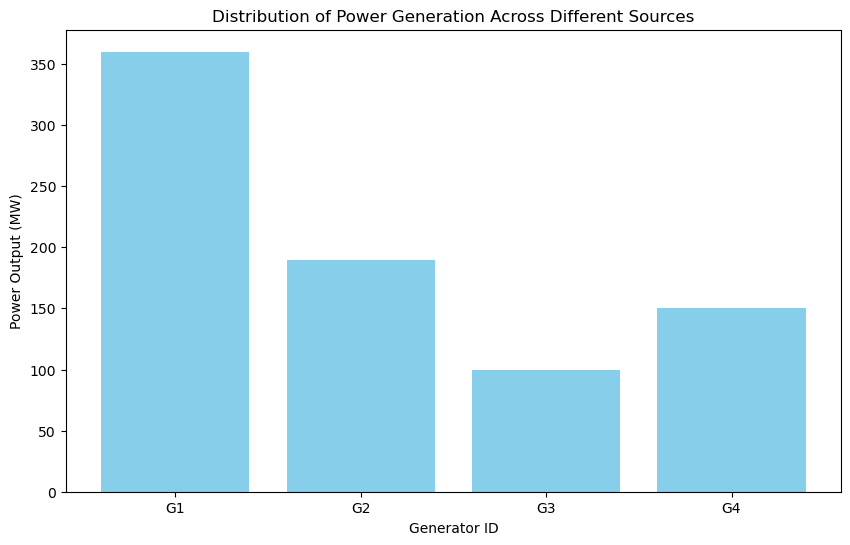

In [49]:
from gurobipy import Model, GRB
import matplotlib.pyplot as plt

# Made up data for power generation sources as a starting point 
power_generation_sources = [
    {"Generator_ID": "G1", "Type": "Coal", "Capacity_MW": 500, "Variable_Cost_per_MWh": 30, "CO2_Emissions_per_MWh": 900, "Region": "North"},
    {"Generator_ID": "G2", "Type": "Natural Gas", "Capacity_MW": 300, "Variable_Cost_per_MWh": 45, "CO2_Emissions_per_MWh": 400, "Region": "South"},
    {"Generator_ID": "G3", "Type": "Solar", "Capacity_MW": 100, "Variable_Cost_per_MWh": 10, "CO2_Emissions_per_MWh": 0, "Region": "East"},  # Added a small variable cost to Solar
    {"Generator_ID": "G4", "Type": "Wind", "Capacity_MW": 150, "Variable_Cost_per_MWh": 10, "CO2_Emissions_per_MWh": 0, "Region": "West"}    # Added a small variable cost to Wind
]

# Total Demand Constraint (in MW)
total_demand = 800  # Example total demand value

# Create a new model
m = Model("Electricity_Planning")

# Add generator power production variables
gen_powers = {}
for gen in power_generation_sources:
    gen_powers[gen['Generator_ID']] = m.addVar(ub=gen['Capacity_MW'], name=f"power_{gen['Generator_ID']}")

# CO2 Emissions Limit Constraint
total_CO2_limit = 400000  # Adjusted CO2 limit in kg
min_renewable_percentage = 0.25  # Adjusted renewable percentage to 25%

# Create model
CO2_emissions = sum(gen['CO2_Emissions_per_MWh'] * gen_powers[gen['Generator_ID']] for gen in power_generation_sources)
m.addConstr(CO2_emissions <= total_CO2_limit, "CO2_emission_limit")

# Minimum Renewable Energy Usage Constraint
total_renewable_gen = sum(gen_powers[gen['Generator_ID']] for gen in power_generation_sources if gen['Type'] in ['Solar', 'Wind'])
m.addConstr(total_renewable_gen >= min_renewable_percentage * sum(gen_powers.values()), "min_renewable_usage")

# Total Demand Constraint
m.addConstr(sum(gen_powers[gen['Generator_ID']] for gen in power_generation_sources) == total_demand, "total_demand")

# Cost minimization objective
m.setObjective(
    sum(gen['Variable_Cost_per_MWh'] * gen_powers[gen['Generator_ID']] for gen in power_generation_sources),
    GRB.MINIMIZE)

# Optimize the model
m.optimize()

# Check if the model was optimized successfully
if m.status == GRB.OPTIMAL:
    print("Optimal solution found.")
    # Extract the solution for visualization
    power_output = {gen['Generator_ID']: gen_powers[gen['Generator_ID']].X for gen in power_generation_sources}

    # Prepare data for bar chart
    labels = list(power_output.keys())
    values = list(power_output.values())

    # Create bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color='skyblue')
    plt.xlabel('Generator ID')
    plt.ylabel('Power Output (MW)')
    plt.title('Distribution of Power Generation Across Different Sources')
    plt.show()
else:
    print("No optimal solution found.")


## Model 2: Mixed-Integer Power Generation Optimization
### Objective:  
Same as Model 1, minimize total variable cost.
#### Generators:  
Similar setup with coal, natural gas, solar, and wind.
#### What changed:
Includes binary on/off variables for each generator.
Adds a minimum generation level constraint when a generator is on.
#### Constraints: 
Similar to Model 1 but adjusted for CO2 limit and renewable energy requirement.
#### Decision Variables: 
Power output and operational status (on/off) for each generator.
#### Optimization Output:
Prints generator status, power output, cost, and emissions. Visualized as a bar chart with additional on/off status information.

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11 rows, 8 columns and 26 nonzeros
Model fingerprint: 0xd926f9d4
Variable types: 4 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e-01, 9e+02]
  Objective range  [1e+01, 4e+01]
  Bounds range     [1e+00, 5e+02]
  RHS range        [7e+02, 4e+05]
Presolve removed 11 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 17650 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.765000000000e+04, best bound 1.765000000000e+04, gap 0.0000%
Optimal solution found.

Generator G1 (Coal): Status = On, Power Output = 340.00 MW, Cost = $10200.00, CO2 Emissions = 306000.00 kg
Generator G2 (Natural Gas): Status = On,

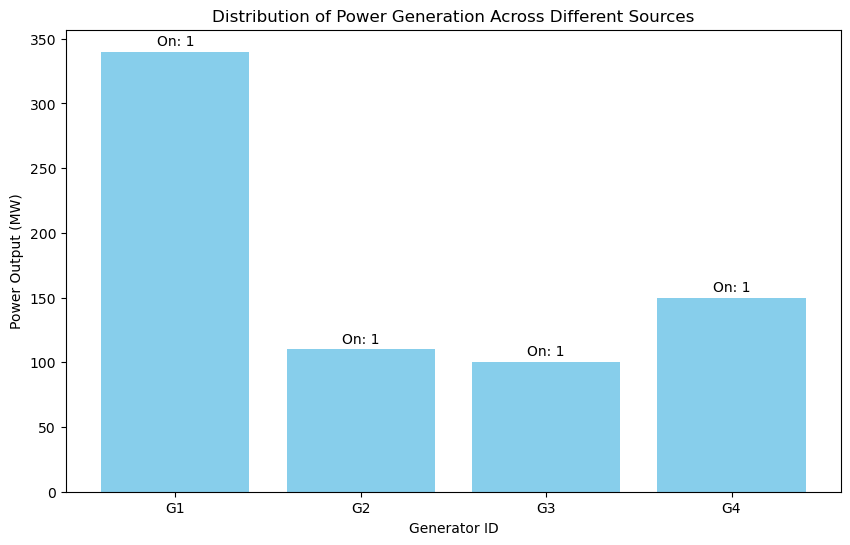

In [52]:
# from gurobipy import Model, GRB
# import matplotlib.pyplot as plt

# # Assumed data for power generation sources
# power_generation_sources = [
#     {"Generator_ID": "G1", "Type": "Coal", "Capacity_MW": 500, "Variable_Cost_per_MWh": 30, "CO2_Emissions_per_MWh": 900, "Region": "North"},
#     {"Generator_ID": "G2", "Type": "Natural Gas", "Capacity_MW": 300, "Variable_Cost_per_MWh": 45, "CO2_Emissions_per_MWh": 400, "Region": "South"},
#     {"Generator_ID": "G3", "Type": "Solar", "Capacity_MW": 100, "Variable_Cost_per_MWh": 10, "CO2_Emissions_per_MWh": 0, "Region": "East"},
#     {"Generator_ID": "G4", "Type": "Wind", "Capacity_MW": 150, "Variable_Cost_per_MWh": 10, "CO2_Emissions_per_MWh": 0, "Region": "West"}
# ]

# # Adjusted total demand (ensure its within the feasible range)
# total_demand = 700  # Example total demand value

# # Create a new model
# m = Model("Electricity_Planning")

# # Add generator power production variables and binary on/off variables
# gen_powers = {}
# gen_on = {}
# for gen in power_generation_sources:
#     gen_powers[gen['Generator_ID']] = m.addVar(ub=gen['Capacity_MW'], name=f"power_{gen['Generator_ID']}")
#     gen_on[gen['Generator_ID']] = m.addVar(vtype=GRB.BINARY, name=f"on_{gen['Generator_ID']}")

#     # Link power generation to on/off status
#     m.addConstr(gen_powers[gen['Generator_ID']] <= gen_on[gen['Generator_ID']] * gen['Capacity_MW'])
#     # Minimum generation level constraint (e.g., 10% of capacity if on)
#     m.addConstr(gen_powers[gen['Generator_ID']] >= gen_on[gen['Generator_ID']] * 0.10 * gen['Capacity_MW'])

# # Adjusted CO2 Emissions Limit Constraint
# total_CO2_limit = 350000  # Adjusted CO2 limit in kg
# CO2_emissions = sum(gen['CO2_Emissions_per_MWh'] * gen_powers[gen['Generator_ID']] for gen in power_generation_sources)
# m.addConstr(CO2_emissions <= total_CO2_limit, "CO2_emission_limit")

# # Adjusted Minimum Renewable Energy Usage Constraint
# min_renewable_percentage = 0.15  # Adjusted renewable percentage to 15%
# total_renewable_gen = sum(gen_powers[gen['Generator_ID']] for gen in power_generation_sources if gen['Type'] in ['Solar', 'Wind'])
# m.addConstr(total_renewable_gen >= min_renewable_percentage * sum(gen_powers.values()), "min_renewable_usage")

# # Total Demand Constraint
# m.addConstr(sum(gen_powers[gen['Generator_ID']] for gen in power_generation_sources) == total_demand, "total_demand")

# # Cost minimization objective
# m.setObjective(
#     sum(gen['Variable_Cost_per_MWh'] * gen_powers[gen['Generator_ID']] for gen in power_generation_sources),
#     GRB.MINIMIZE)

# # Optimize the model
# m.optimize()

# # Check if the model was optimized or infeasible

# if m.status == GRB.OPTIMAL:
#     print("Optimal solution found.\n")
    
#     # Print generator statuses and power outputs
#     total_cost = 0
#     total_CO2_emitted = 0
#     for gen in power_generation_sources:
#         gen_id = gen['Generator_ID']
#         status = 'On' if gen_on[gen_id].X > 0.5 else 'Off'  # Assuming binary variable > 0.5 as 'On'
#         power = gen_powers[gen_id].X
#         cost = power * gen['Variable_Cost_per_MWh']
#         CO2 = power * gen['CO2_Emissions_per_MWh']
        
#         total_cost += cost
#         total_CO2_emitted += CO2

#         print(f"Generator {gen_id} ({gen['Type']}): Status = {status}, Power Output = {power:.2f} MW, Cost = ${cost:.2f}, CO2 Emissions = {CO2:.2f} kg")

#     # Print total cost and CO2 emissions
#     print("\nTotal Cost of Power Generation: ${:.2f}".format(total_cost))
#     print("Total CO2 Emissions: {:.2f} kg".format(total_CO2_emitted))
#     # Prepare data for bar chart
#     labels = list(power_output.keys())
#     values = list(power_output.values())

#     # Create bar chart
#     plt.figure(figsize=(10, 6))
#     plt.bar(labels, values, color='skyblue')
#     plt.xlabel('Generator ID')
#     plt.ylabel('Power Output (MW)')
#     plt.title('Distribution of Power Generation Across Different Sources')
#     for i, label in enumerate(labels):
#         plt.text(i, values[i] + 5, f'On: {generator_status[label]:.0f}', ha='center')
#     plt.show()
# else:
#     print("No optimal solution found.")




## Model 3: Time-Dependent, Large-Scale Optimization
### Objective: 
Minimize total variable cost over multiple time periods.
#### Generators: 
Expanded to 20 generators with a variety of types (including nuclear and hydro) and random characteristics.
#### What changed:
Time periods: Optimizes across 24 hours.
Larger and more diverse set of generators.
#### Constraints:
Hourly Demand: Each hour has its own demand constraint.
Capacity and operational constraints are similar to Model 2 but applied per time period.
#### Decision Variables: 
Power output and on/off status for each generator in each time period.
#### Optimization Output: 
Displays power output for each generator across all time periods.

In [55]:
from gurobipy import Model, GRB
import matplotlib.pyplot as plt
import random

# Create a dataset of 20 generators with varied characteristics
power_generation_sources = []
types = ["Coal", "Natural Gas", "Solar", "Wind", "Nuclear", "Hydro"]
regions = ["North", "South", "East", "West", "Central"]

for i in range(1, 21):
    gen_type = random.choice(types)
    capacity = random.randint(100, 1000)  # Random capacity between 100 and 1000 MW
    variable_cost = random.randint(5, 50) if gen_type != "Solar" and gen_type != "Wind" else 0  # Zero cost for Solar and Wind
    CO2_emissions = random.randint(0, 1000) if gen_type != "Solar" and gen_type != "Wind" else 0  # Zero emissions for Solar and Wind
    region = random.choice(regions)

    power_generation_sources.append({
        "Generator_ID": f"G{i}",
        "Type": gen_type,
        "Capacity_MW": capacity,
        "Variable_Cost_per_MWh": variable_cost,
        "CO2_Emissions_per_MWh": CO2_emissions,
        "Region": region
    })

# Time periods (e.g., hourly for one day)
time_periods = range(24)  # 24 hours in a day

# Create a new model
m = Model("Electricity_Planning_Time_Dependent")

# Power production variables and binary on/off variables for each generator and time period
gen_powers = {}
gen_on = {}
for t in time_periods:
    for gen in power_generation_sources:
        gen_id = f"{gen['Generator_ID']}_t{t}"
        gen_powers[gen_id] = m.addVar(ub=gen['Capacity_MW'], name=f"power_{gen_id}")
        gen_on[gen_id] = m.addVar(vtype=GRB.BINARY, name=f"on_{gen_id}")

        # Link power generation to on/off status
        m.addConstr(gen_powers[gen_id] <= gen_on[gen_id] * gen['Capacity_MW'])
        # Minimum generation level constraint
        m.addConstr(gen_powers[gen_id] >= gen_on[gen_id] * 0.10 * gen['Capacity_MW'])

# Demand for each hour (made-up numbers)
hourly_demand = [sum(random.randint(50, 150) for _ in range(20)) for _ in range(24)]
for t in time_periods:
    m.addConstr(sum(gen_powers[f"{gen['Generator_ID']}_t{t}"] for gen in power_generation_sources) == hourly_demand[t], f"demand_t{t}")
    
#Objective Funtion
m.setObjective(sum(gen['Variable_Cost_per_MWh'] * gen_powers[f"{gen['Generator_ID']}_t{t}"]
                   for gen in power_generation_sources for t in time_periods), GRB.MINIMIZE)

# Optimize the model
m.optimize()

if m.status == GRB.OPTIMAL:
    print("Optimal solution found.\n")
    # display the results
    for t in time_periods:
        print(f"Time Period {t}:")
        for gen in power_generation_sources:
            gen_id = f"{gen['Generator_ID']}_t{t}"
            print(f"  Generator {gen['Generator_ID']} - Power Output: {gen_powers[gen_id].X:.2f} MW")
        print()
else:
    print("No optimal solution found.")



Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 960 columns and 2400 nonzeros
Model fingerprint: 0x9dc558eb
Variable types: 480 continuous, 480 integer (480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [7e+00, 5e+01]
  Bounds range     [1e+00, 1e+03]
  RHS range        [2e+03, 2e+03]
Found heuristic solution: objective 871263.20000
Presolve removed 943 rows and 920 columns
Presolve time: 0.02s
Presolved: 41 rows, 40 columns, 100 nonzeros
Found heuristic solution: objective 34906.000000
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 0.000000e+00, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0   

Optimal solution found.

    Time 0 Time 1 Time 2 Time 3 Time 4 Time 5 Time 6 Time 7 Time 8 Time 9  \
G1   750.0  750.0  750.0  750.0  750.0  750.0  750.0  750.0  750.0  750.0   
G2   343.0  140.0  342.0  260.0  388.0  237.0  378.0  323.0  331.0  342.0   
G3     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
G4     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
G5     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
G6     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
G7     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
G8     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
G9     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
G10  265.0  265.0  265.0  265.0  265.0  265.0  265.0  265.0  265.0  265.0   
G11    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
G12    0.0    0.0    0.0    0.0    0.0    0.0    0.

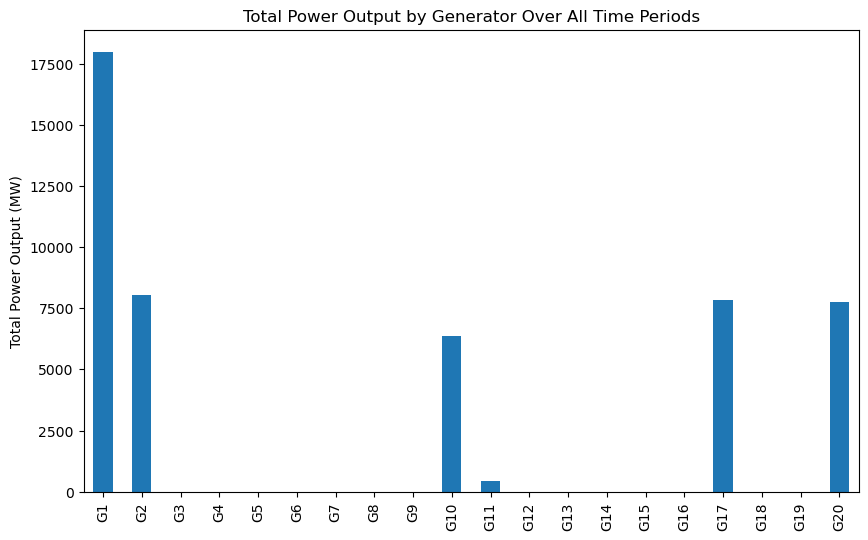

In [54]:
import pandas as pd

if m.status == GRB.OPTIMAL:
    print("Optimal solution found.\n")

    #store te results
    results = pd.DataFrame(index=[gen['Generator_ID'] for gen in power_generation_sources],
                           columns=[f"Time {t}" for t in time_periods])

    for t in time_periods:
        for gen in power_generation_sources:
            gen_id = gen['Generator_ID']
            power_output = gen_powers[f"{gen_id}_t{t}"].X
            results.at[gen_id, f"Time {t}"] = power_output

    print(results)

    # visualization: total power outupt by generator over alltime periods
    total_power_by_generator = results.sum(axis=1)
    total_power_by_generator.plot(kind='bar', figsize=(10, 6))
    plt.ylabel('Total Power Output (MW)')
    plt.title('Total Power Output by Generator Over All Time Periods')
    plt.show()
else:
    print("No optimal solution found.")